In [116]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import torch
import os
from PIL import Image
from math import tan, pi, cos, sin

In [117]:
class LabelDataset(tf.data.Dataset):
    def __init__(self, path, batch_size):
        self.video_paths = [os.path.join(path, dir_path) for dir_path in os.listdir(path) if dir_path.startswith('video')]
        self.num_samples = 0

        # Load the mask shape from the first video path
        mask_sample_path = os.path.join(self.video_paths[0], 'mask.npy')
        mask_shapes = np.load(mask_sample_path).shape

        # Calculate the total number of samples
        self.num_samples = mask_shapes[0] * len(self.video_paths)
        self.batch_size = batch_size

    def _inputs(self):
        return []

    def element_spec(self):
        image_shape = tf.TensorShape([None, None, 3])
        mask_shape = tf.TensorShape([None])
        return (image_shape, mask_shape)

    def _generator(self):
        images_batch = []
        masks_batch = []
        for path in self.video_paths:
            mask_path = os.path.join(path, 'mask.npy')
            masks = np.load(mask_path)

            for i in range(masks.shape[0]): 
                image_path = os.path.join(path, f'image_{i}.png')
                image_data = tf.io.read_file(image_path)

                image = tf.image.decode_png(image_data, channels=3)
                #normalize
                image = tf.cast(image, tf.float32)
                image = ((image / 255.0) - 0.5) * 2.0  # Rescale to [-1, 1].
                image = tf.image.resize(
                    image, (160,240), method=tf.image.ResizeMethod.BILINEAR)
                image = tf.clip_by_value(image, -1., 1.)
                
                mask = tf.convert_to_tensor(masks[i])

                images_batch.append(image)
                masks_batch.append(mask)

                if ((len(images_batch) >= self.batch_size) & (len(masks_batch) >= self.batch_size)):
                    output_images_batch = images_batch[:]
                    output_masks_batch = masks_batch[:]

                    images_batch = []
                    masks_batch = []

                    yield {'image': tf.stack(output_images_batch), 'target': tf.stack(output_masks_batch)}

    def __len__(self):
        return self.num_samples

    def __iter__(self):
        return self._generator()

In [118]:
path = '/Users/keegankelly/NYU/Classes/Deep_Learning/project/dataset_full/train'
custom_dataset = LabelDataset(path, 12).__iter__()

In [119]:
unique_values_1 = set()
unique_values_2 = set()

unique_image_set_1 = []
unique_image_set_2 = []
unique_target_set_1 = []
unique_target_set_2 = []


for data in  custom_dataset:
    for vector_indices in range(data['target'].shape[0]):
        target_unique = set(np.unique(data['target'][vector_indices].numpy()))
        if target_unique - unique_values_1:
            unique_values_1 = unique_values_1.union(target_unique)
            unique_image_set_1.append(data['image'][vector_indices])
            unique_target_set_1.append(data['target'][vector_indices])
            
        elif target_unique - unique_values_2:
            unique_values_2 = unique_values_2.union(target_unique)
            unique_image_set_2.append(data['image'][vector_indices])
            unique_target_set_2.append(data['target'][vector_indices])

In [120]:
def visualize_batch_segments(target, image):
    unique_batches = np.unique(target.numpy())
    num_unique_batches = len(unique_batches)
    
    fig, axes = plt.subplots(1, num_unique_batches, figsize=(5*num_unique_batches, 5))
    axes[0].imshow(tf.cast((image + 1) * (255 / 2), tf.uint8))
    axes[0].set_title(f"Image")
    
    for batch_num in range(1, num_unique_batches):
        # Create a mask for the current batch
        batch_mask = tf.cast(target == unique_batches[batch_num], tf.float32)
        
        # Apply the mask to the image
        masked_image = tf.cast(image, tf.float32) * tf.expand_dims(batch_mask, axis=-1)
        
        # Plot the masked image and the mask itself
        axes[batch_num].imshow(tf.cast((masked_image + 1) * (255 / 2), tf.uint8))
        axes[batch_num].set_title(f"Code {unique_batches[batch_num]} in Image")
        #axes[2].imshow(batch_mask, cmap='gray')
        #axes[2].set_title(f"Segment {batch_num} Mask")
    plt.show()

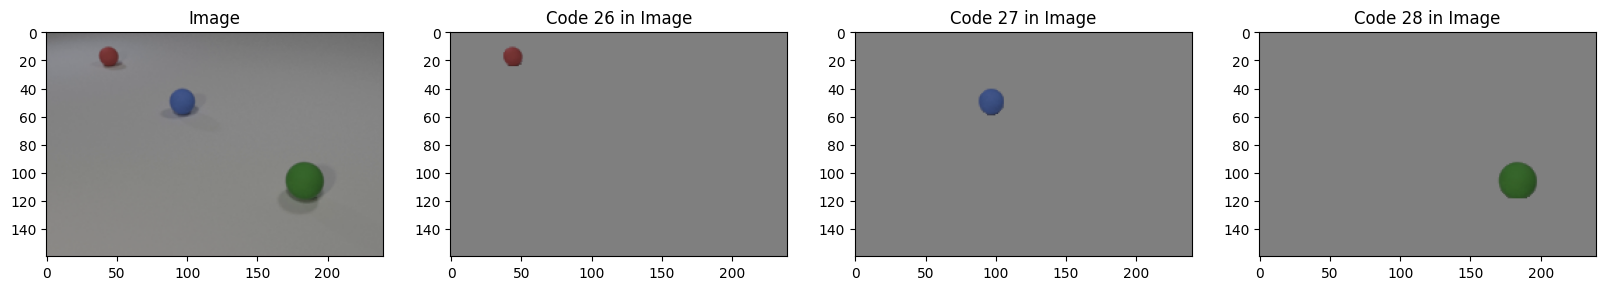

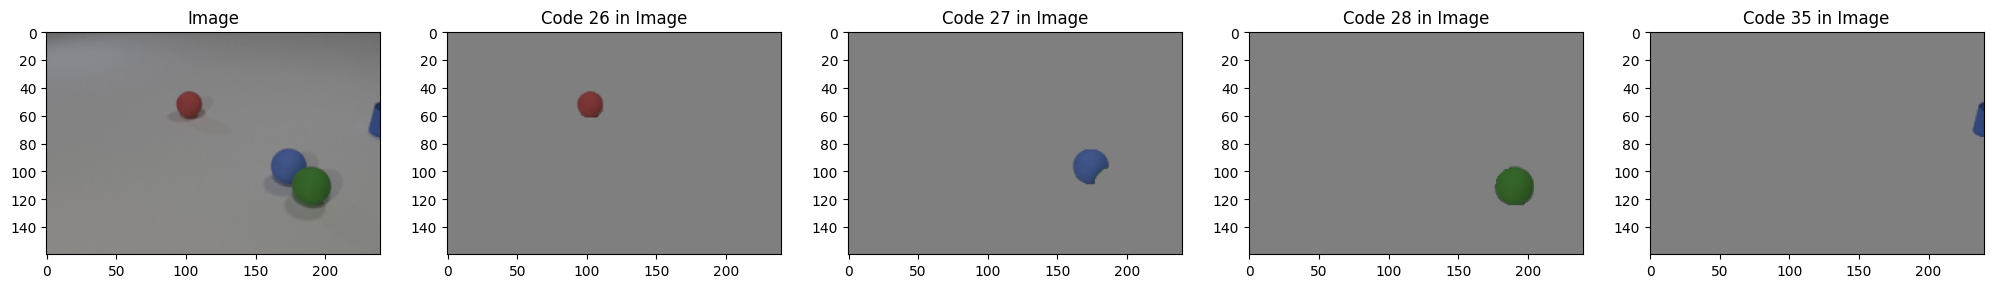

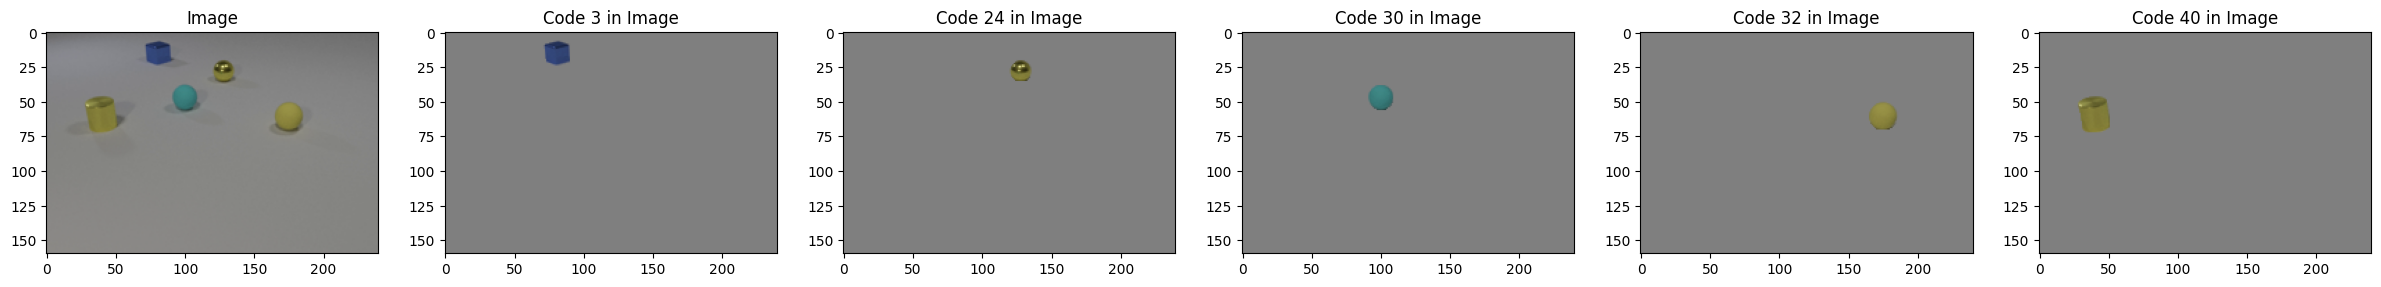

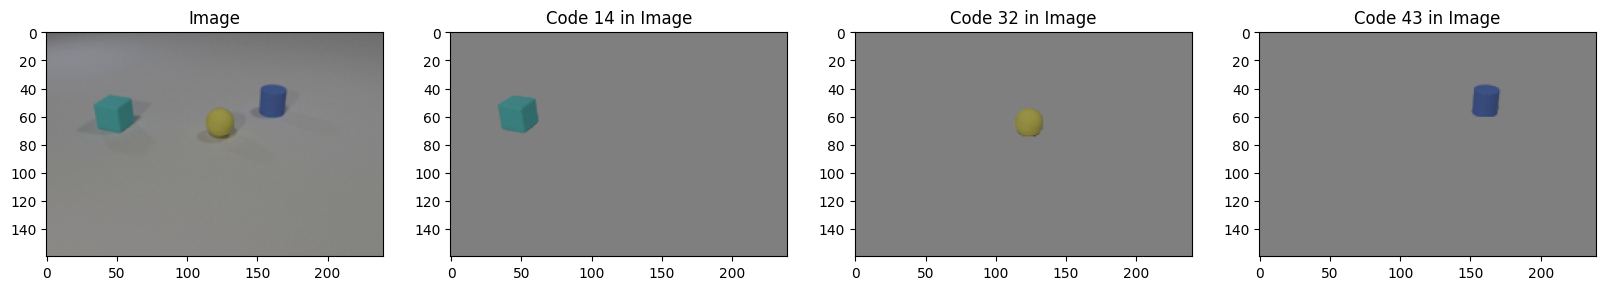

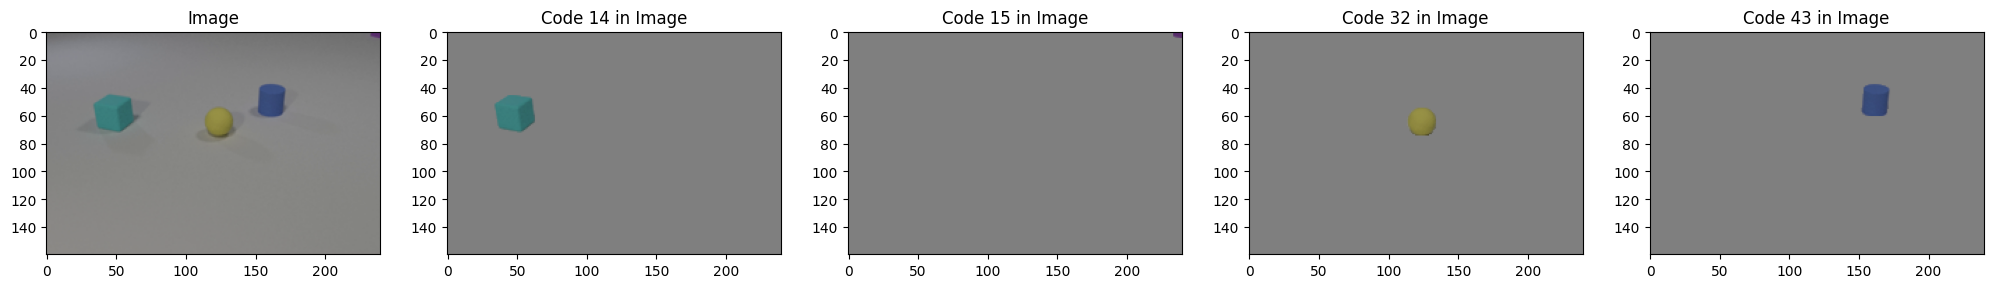

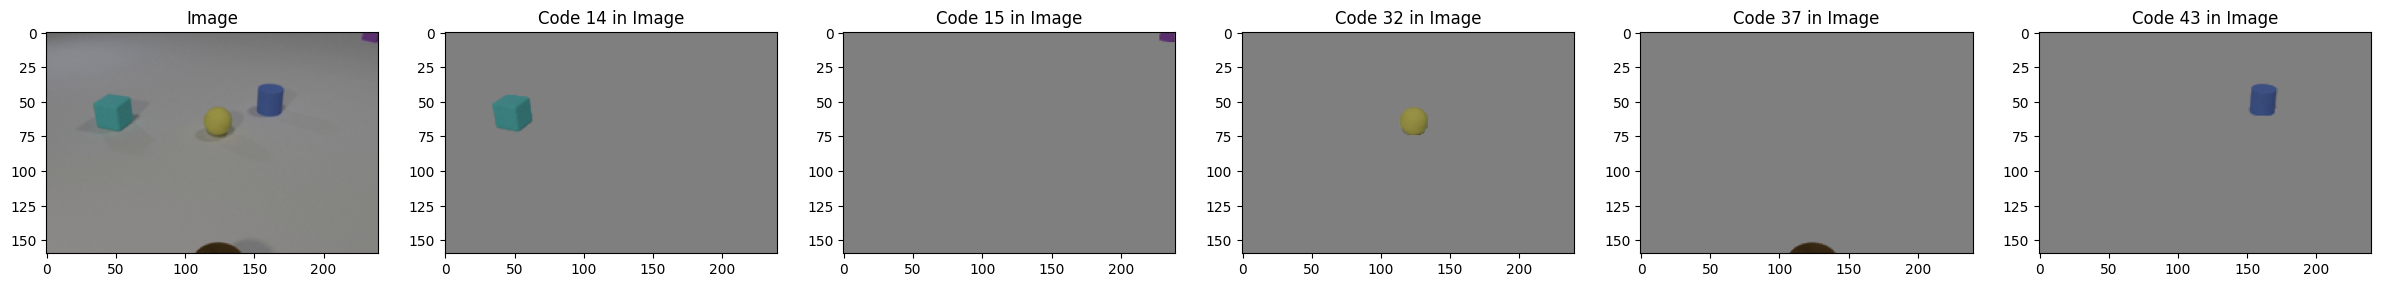

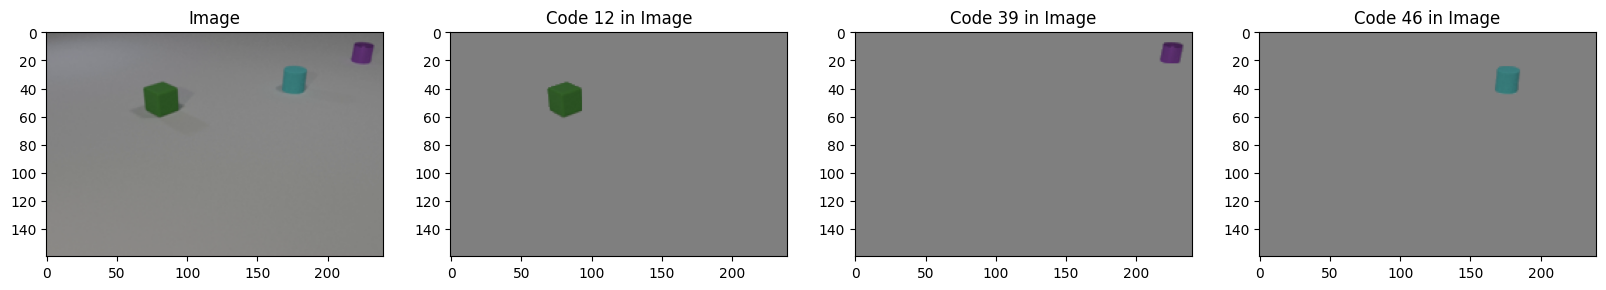

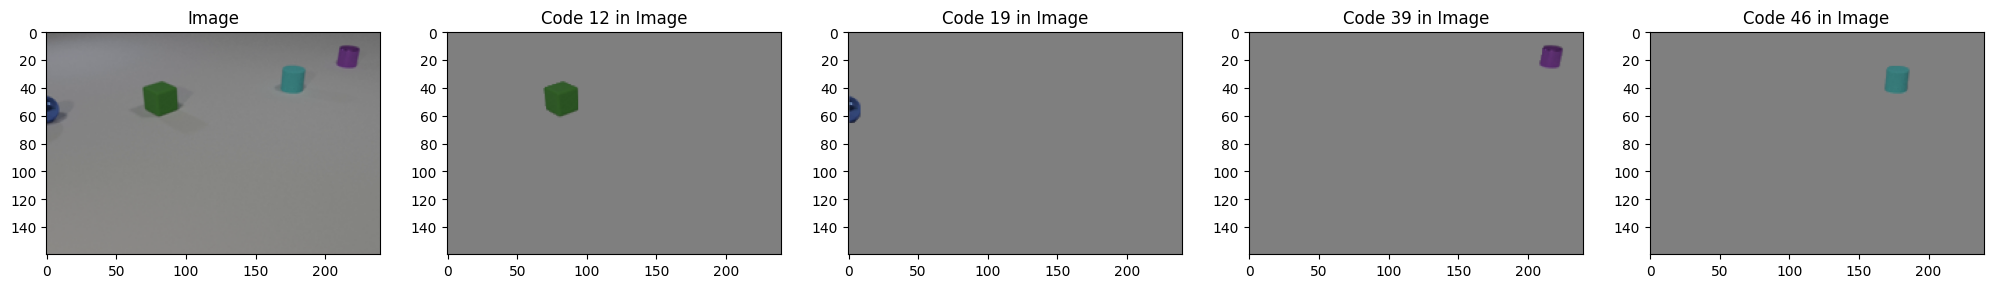

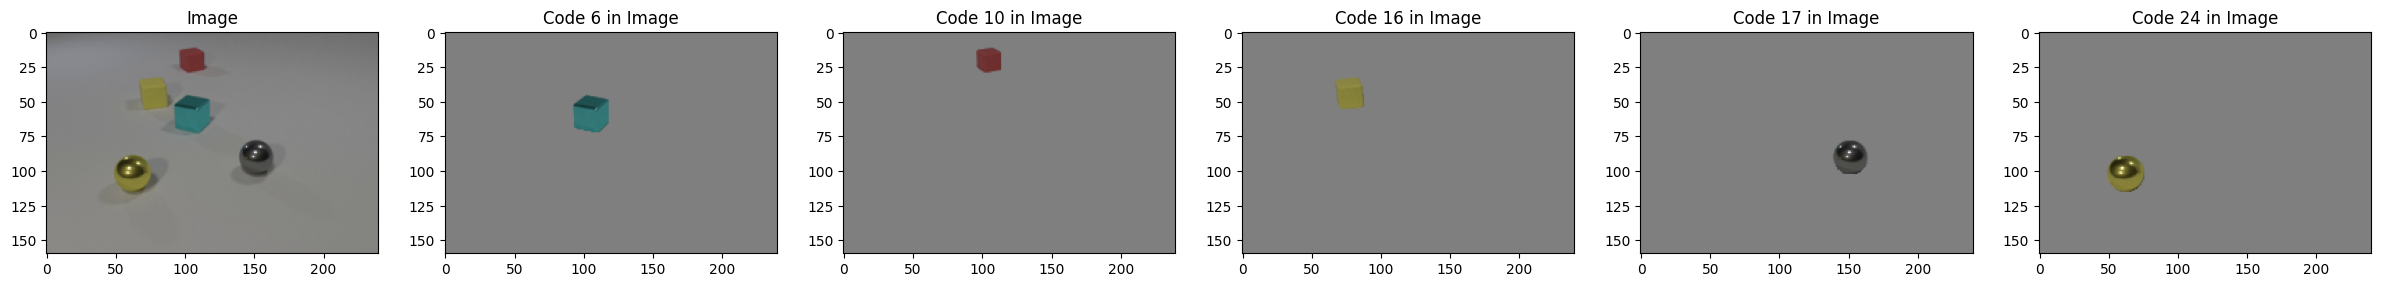

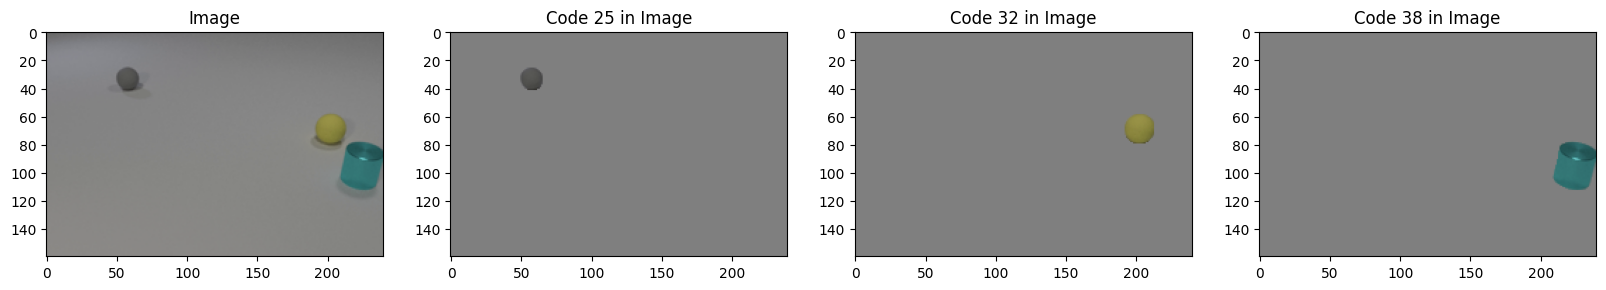

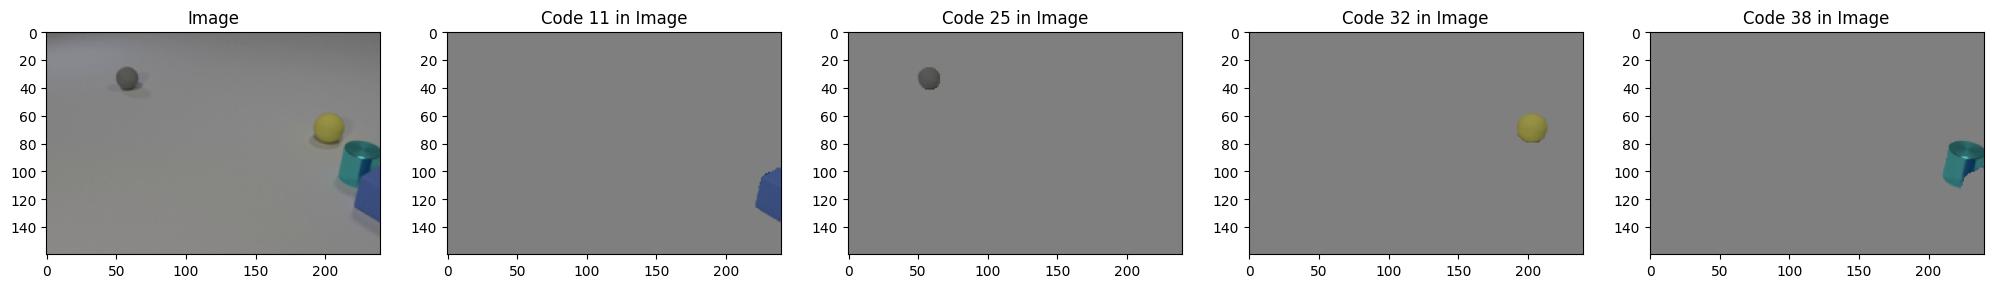

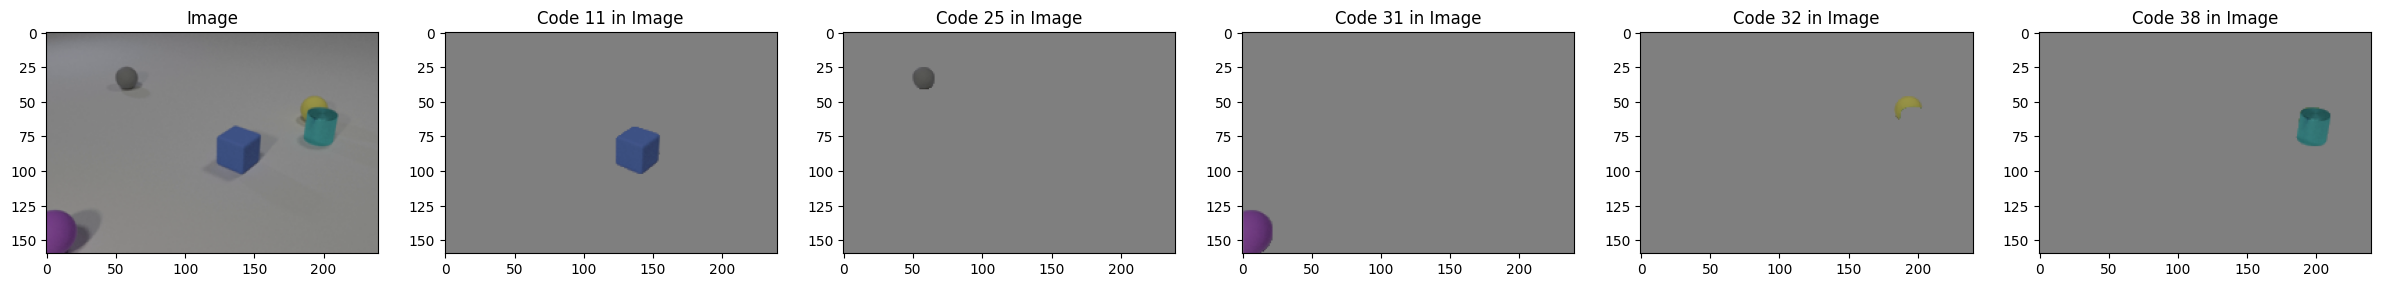

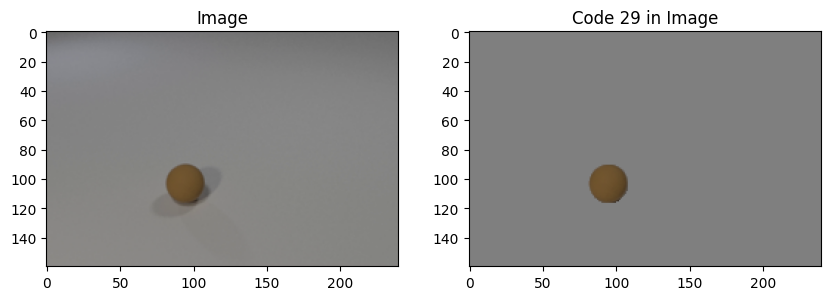

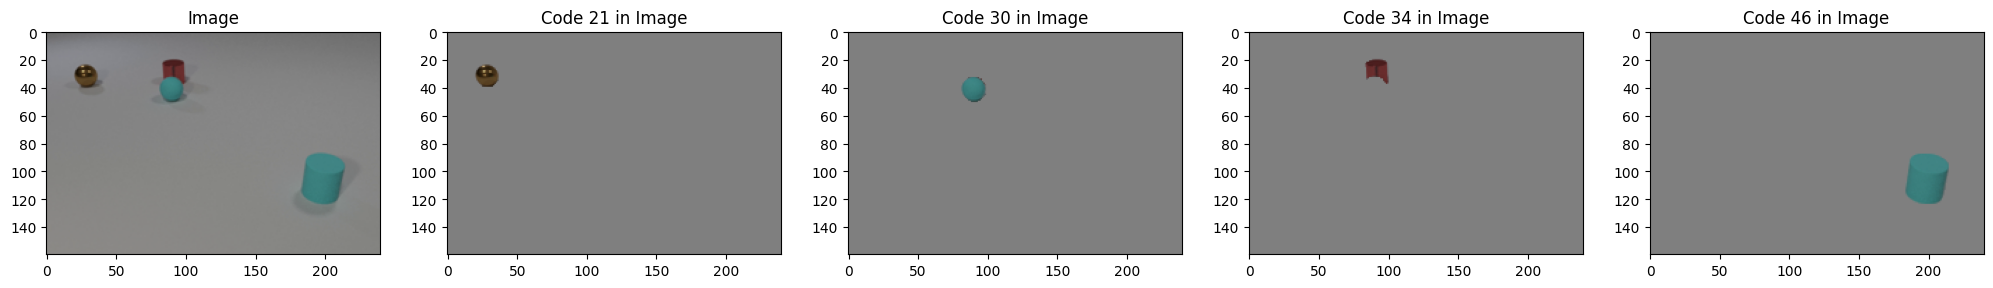

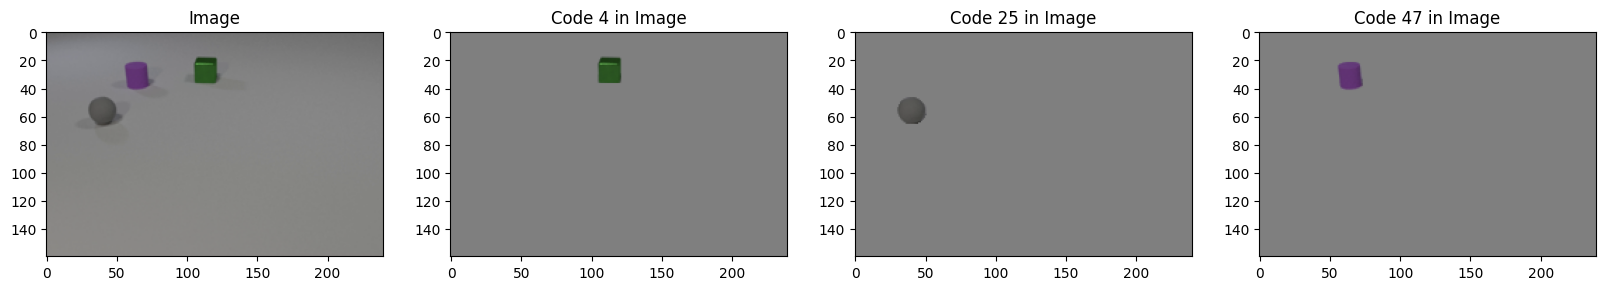

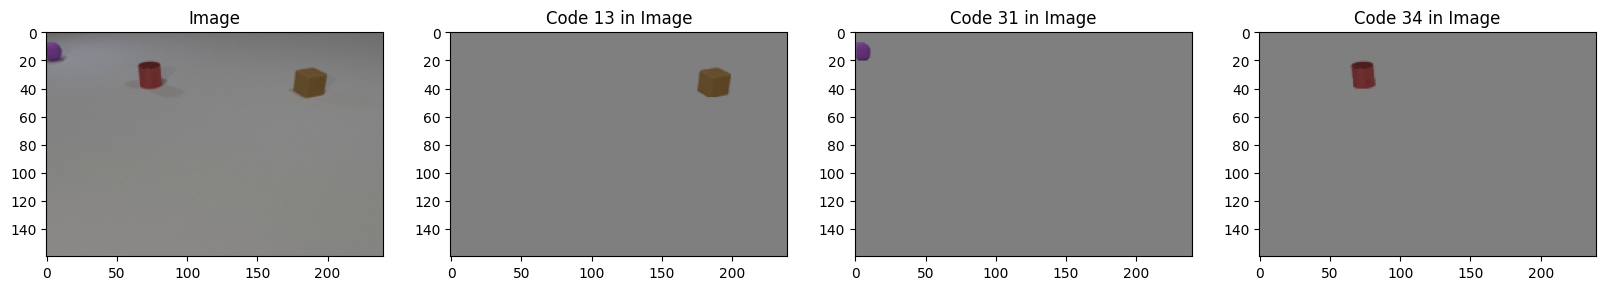

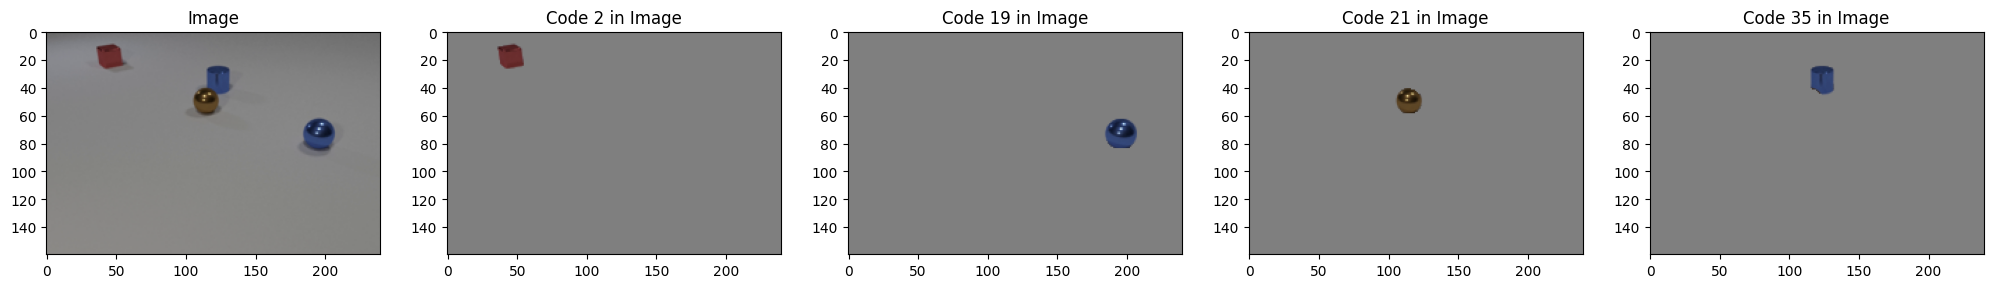

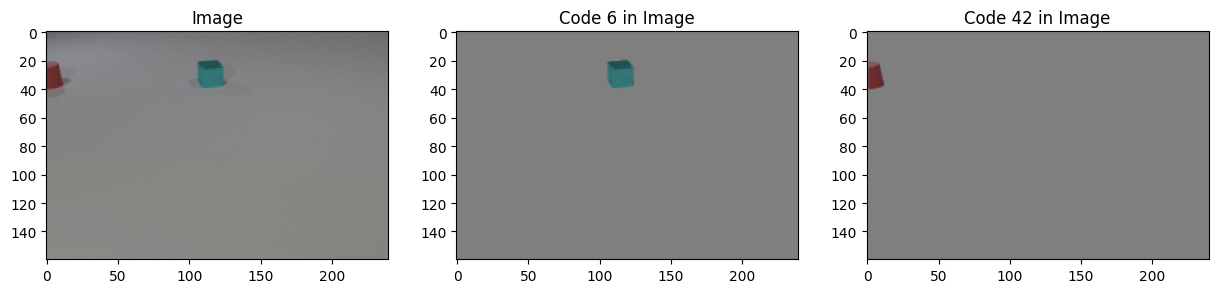

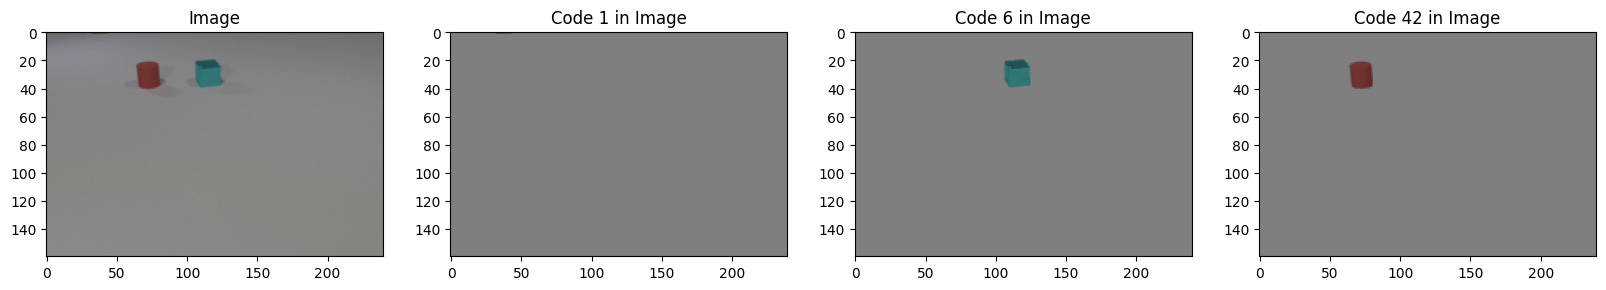

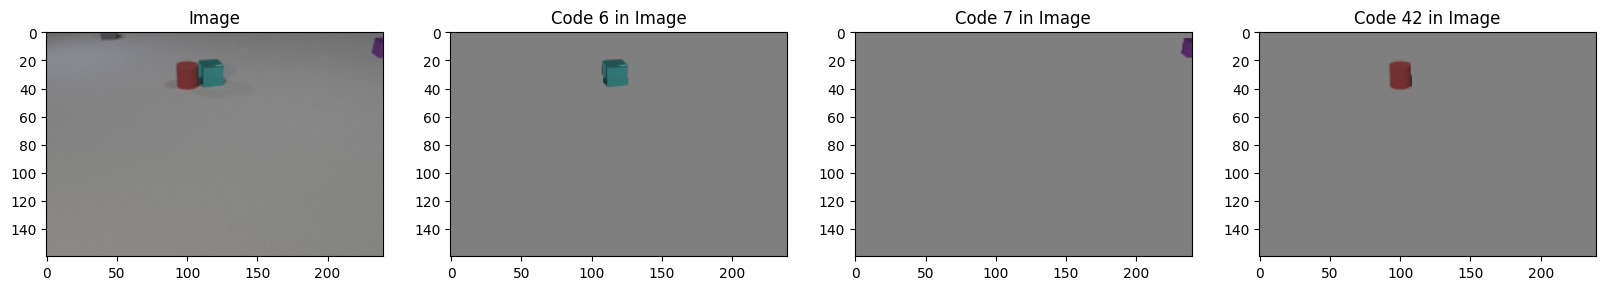

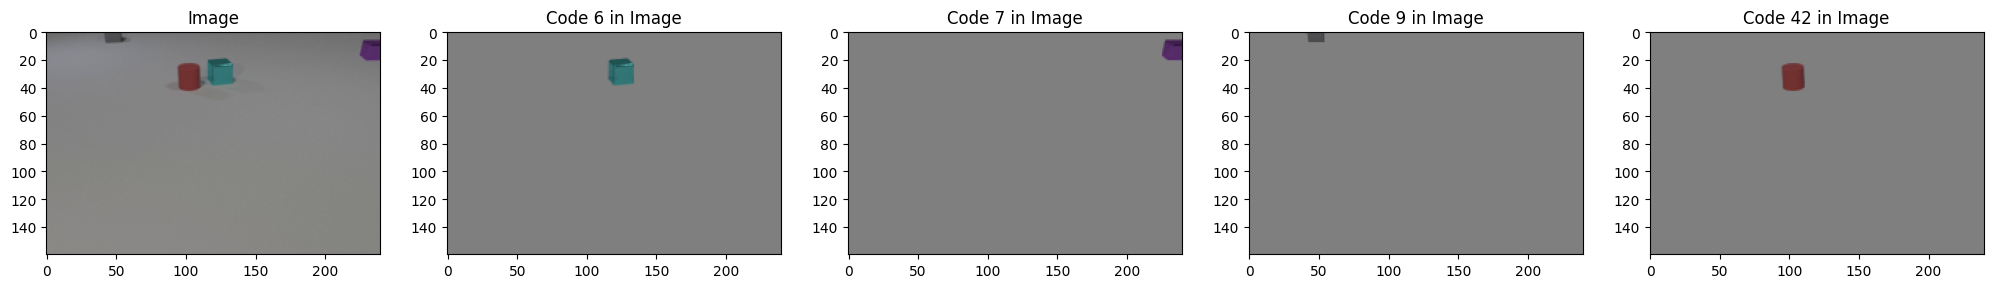

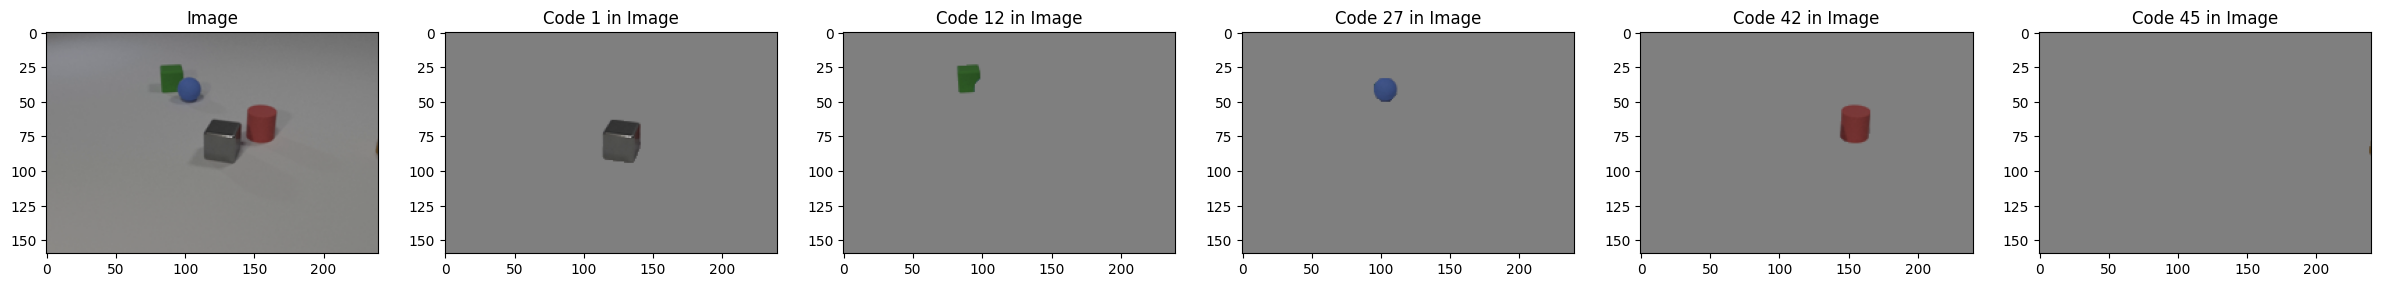

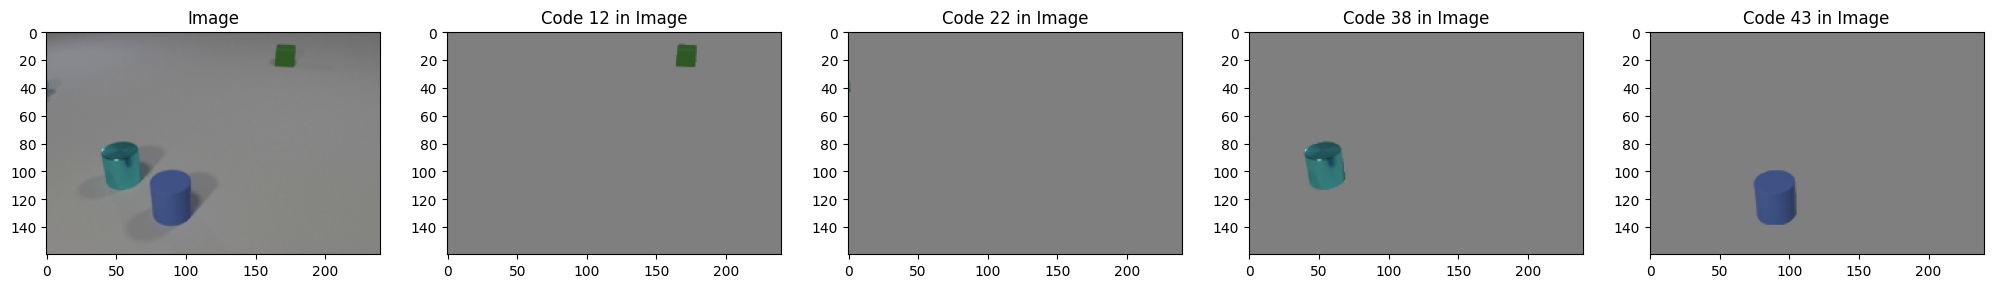

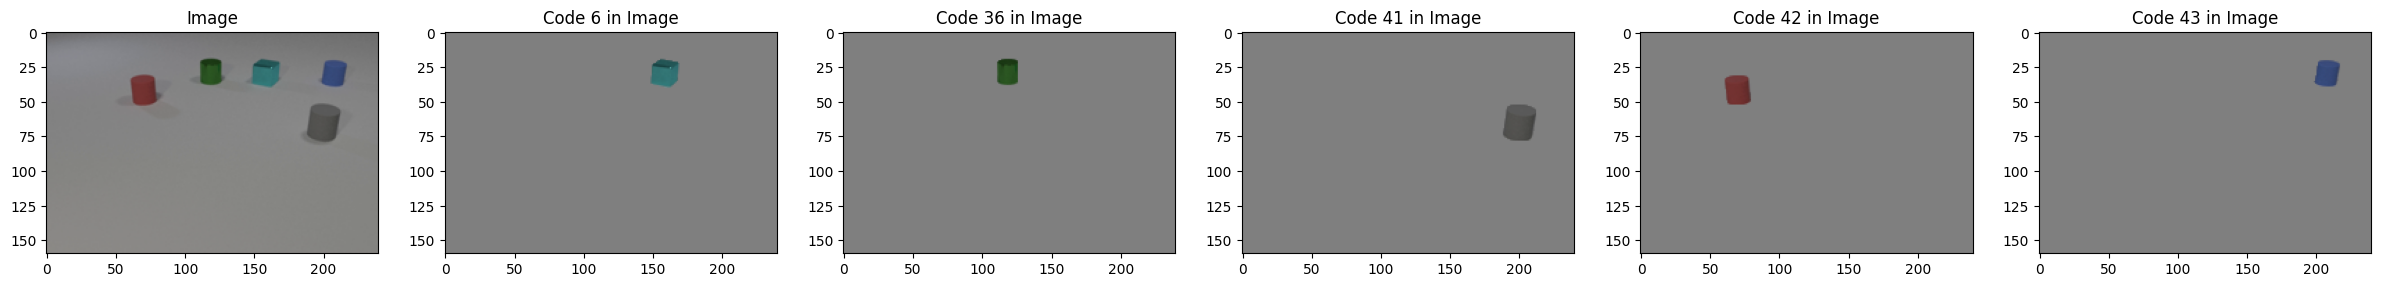

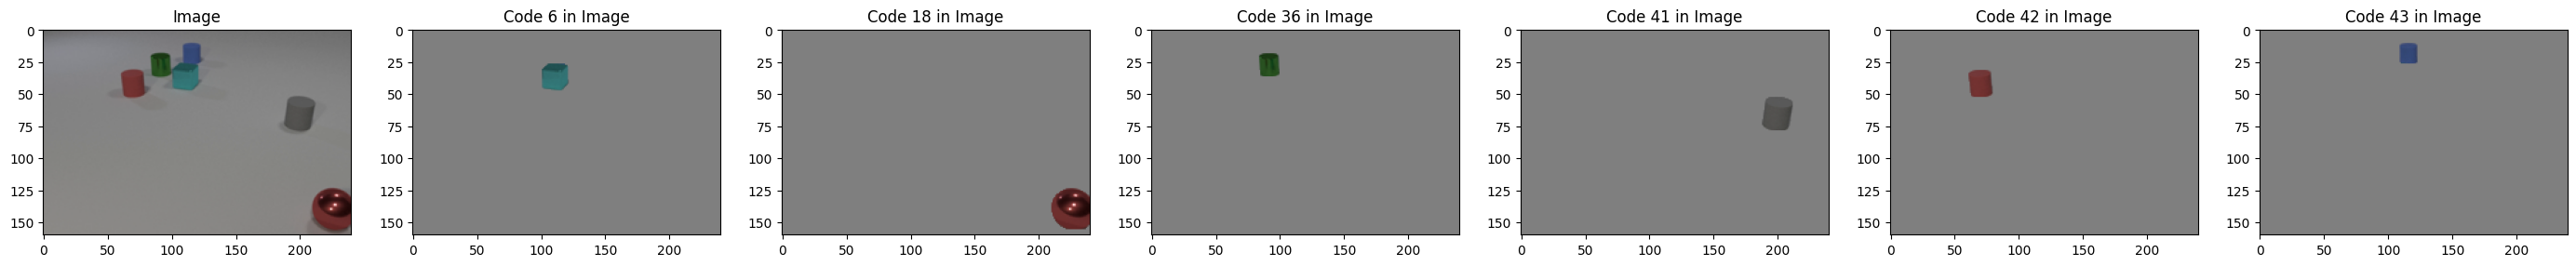

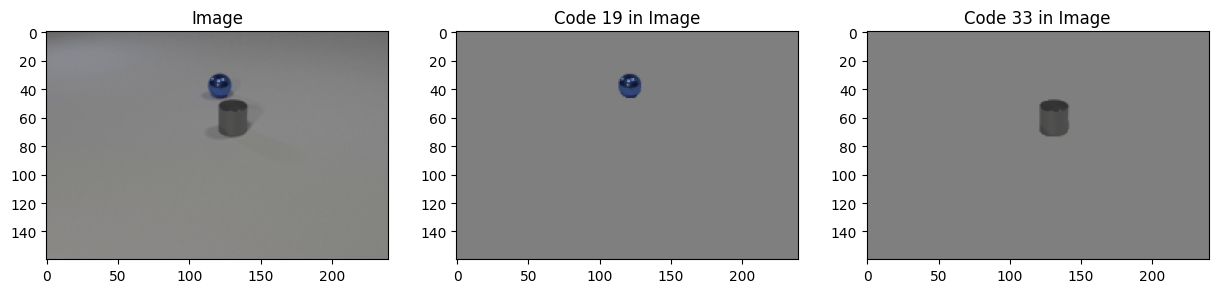

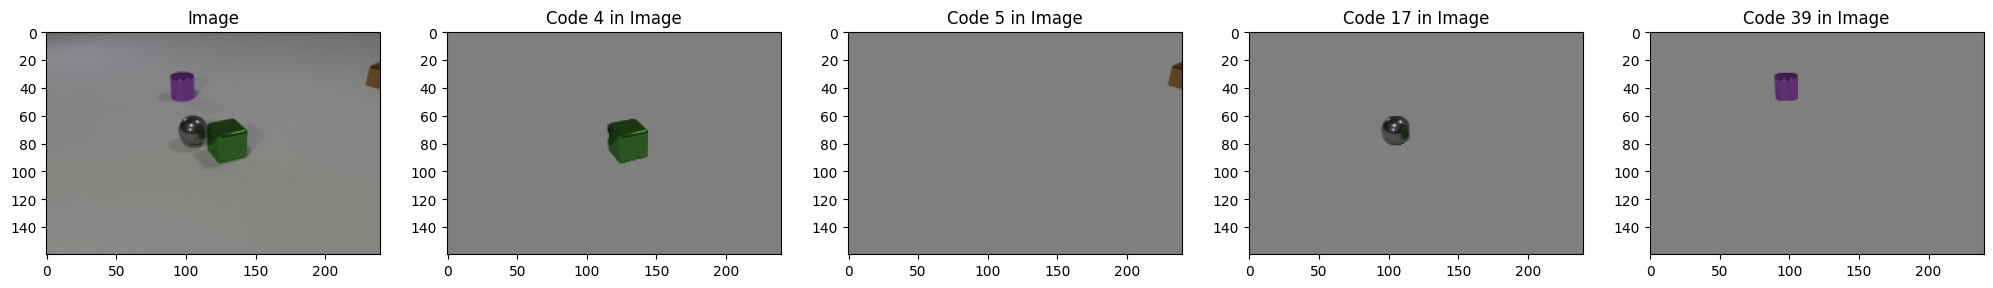

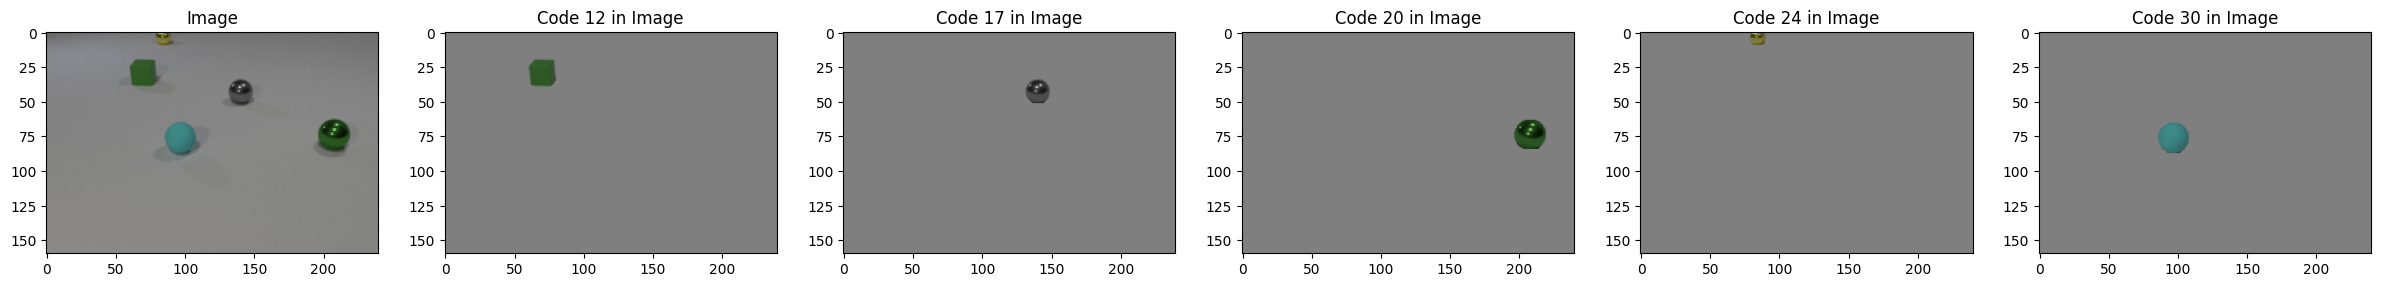

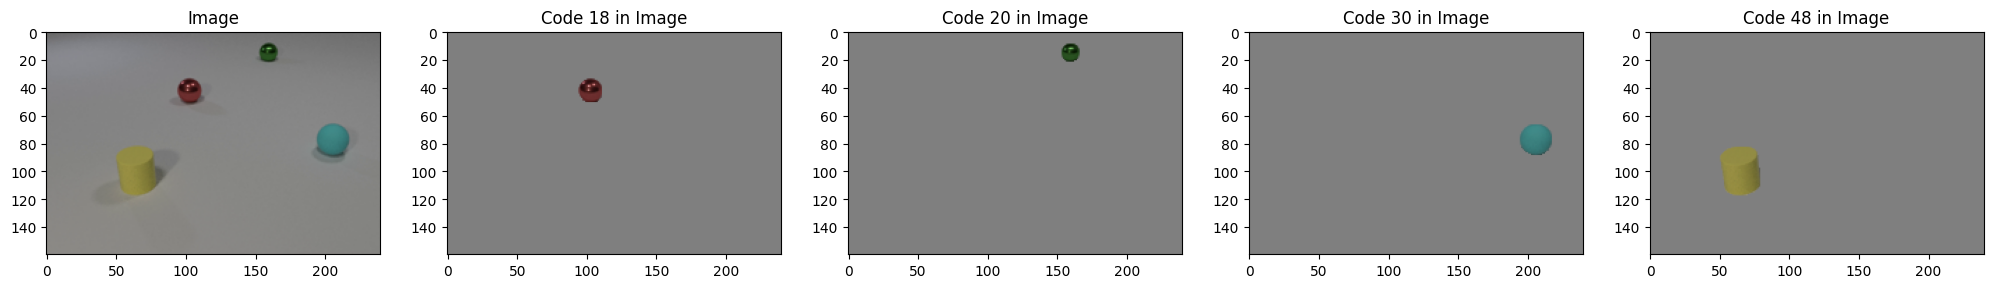

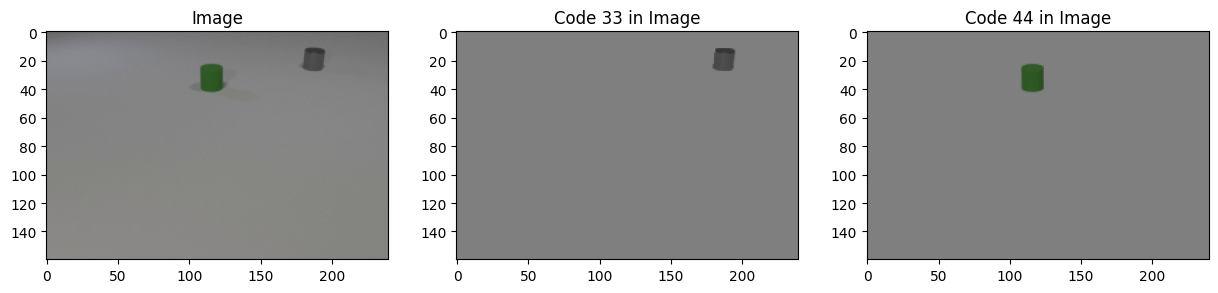

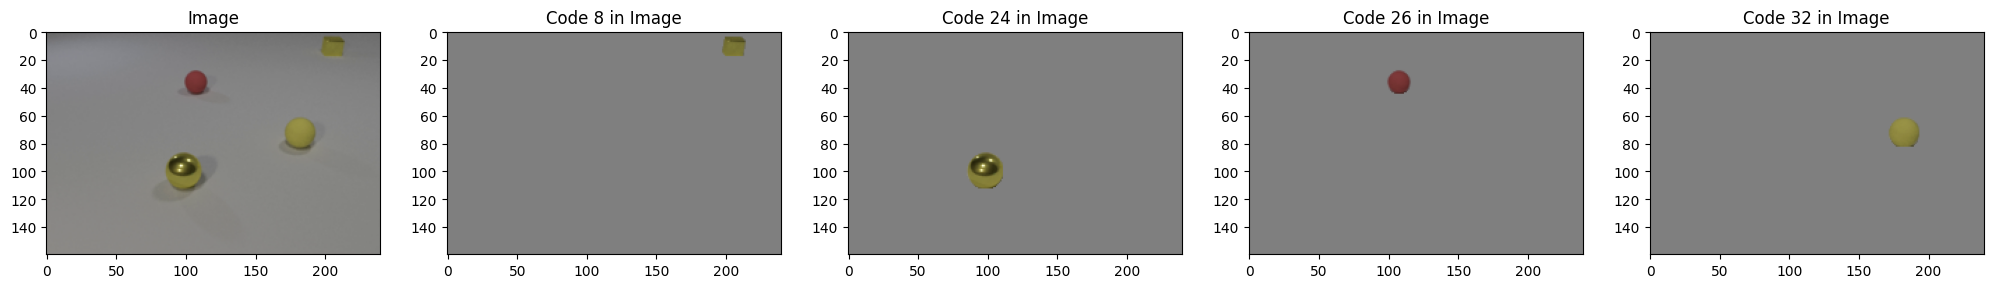

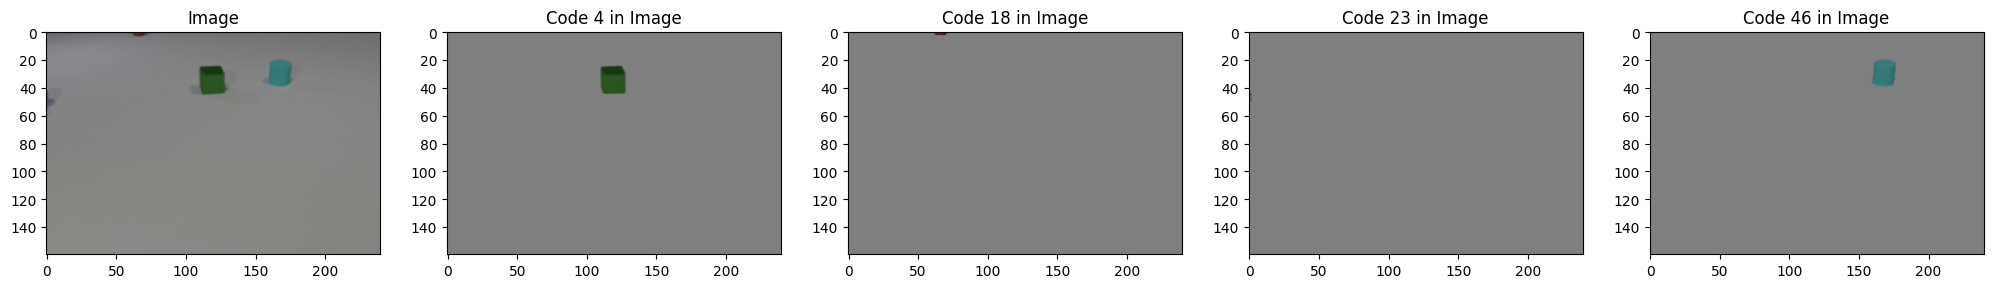

In [121]:
for image_num in range(len(unique_image_set_1)):
    visualize_batch_segments(unique_target_set_1[image_num], unique_image_set_1[image_num])

In [122]:
shape_dict = {'cube':0, 'cylinder':1, 'sphere':2}
material_dict = {'rubber':0, 'metal':1}
color_dict = {'gray':0, 'blue':1, 'brown':2, 'yellow':3, 'red':4, 'green':5, 'purple':6, 'cyan':7}
size_dict = {'small':0, 'large':1}

In [218]:
import tensorflow_datasets as tfds

#data.py format 
features = {
    "objects": tfds.features.Sequence({
        "color": tfds.features.ClassLabel(
            names=list(color_dict.keys())),
        "material": tfds.features.ClassLabel(names=list(material_dict.keys())),
        "shape": tfds.features.ClassLabel(
            names=list(shape_dict.keys())),
        "size": tfds.features.ClassLabel(names=list(size_dict.keys())),
        "3d_coords": tfds.features.Tensor(shape=(3,), dtype=np.float32), 
        }),
    }
features=tfds.features.FeaturesDict(features)

features


FeaturesDict({
    'objects': Sequence({
        'color': ClassLabel(shape=(), dtype=int64, num_classes=8),
        'material': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'shape': ClassLabel(shape=(), dtype=int64, num_classes=3),
        'size': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
})

In [219]:
import pandas as pd

#get objects from first image 
img1 = [code_characteristics[i] for i in np.unique(unique_target_set_1[0].numpy())[1:]]

#add coordinates (this is just the first object for now)
img1 = [dict(item, coords=objects_3d_coords[0]) for item in img1]

#this tensor slice dataset is not the right format
# dataset = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(img1).to_dict(orient="list"))

img1

#need to introduce our data as records?
# for image_obj in np.unique(unique_target_set_1[0].numpy())[1:]:
#     # fname = os.path.basename(image_obj)
#     record = {
#           "file_name": '1',
#           "objects": img1[0]
# #         "objects": [{attr: obj[attr] for attr in attrs} for obj in objects],  # pylint: disable=g-complex-comprehension
#       }
# record



[{'shape': 'sphere',
  'material': 'rubber',
  'color': 'red',
  'size': 'small',
  'coords': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-13.858587, -14.530024,  15.19164 ], dtype=float32)>},
 {'shape': 'sphere',
  'material': 'rubber',
  'color': 'blue',
  'size': 'small',
  'coords': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-13.858587, -14.530024,  15.19164 ], dtype=float32)>},
 {'shape': 'sphere',
  'material': 'rubber',
  'color': 'green',
  'size': 'small',
  'coords': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-13.858587, -14.530024,  15.19164 ], dtype=float32)>}]

In [148]:
#add zero for background?
code_characteristics = { 1:{'shape':'cube', 'material':'metal', 'color': 'gray', 'size': 'small'},
                         2:{'shape':'cube', 'material':'metal', 'color': 'red', 'size': 'small'},
                         3:{'shape':'cube', 'material':'metal', 'color': 'blue', 'size': 'small'},
                         4:{'shape':'cube', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                         5:{'shape':'cube', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                         6:{'shape':'cube', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                         7:{'shape':'cube', 'material':'metal', 'color': 'purple', 'size': 'small'},
                         8:{'shape':'cube', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                         9:{'shape':'cube', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        10:{'shape':'cube', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        11:{'shape':'cube', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        12:{'shape':'cube', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        13:{'shape':'cube', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        14:{'shape':'cube', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        15:{'shape':'cube', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        16:{'shape':'cube', 'material':'rubber', 'color': 'yellow', 'size': 'small'}, 
                        17:{'shape':'sphere', 'material':'metal', 'color': 'gray', 'size': 'small'},
                        18:{'shape':'sphere', 'material':'metal', 'color': 'red', 'size': 'small'},
                        19:{'shape':'sphere', 'material':'metal', 'color': 'blue', 'size': 'small'},
                        20:{'shape':'sphere', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                        21:{'shape':'sphere', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                        22:{'shape':'sphere', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                        23:{'shape':'sphere', 'material':'metal', 'color': 'purple', 'size': 'small'},
                        24:{'shape':'sphere', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                        25:{'shape':'sphere', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        26:{'shape':'sphere', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        27:{'shape':'sphere', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        28:{'shape':'sphere', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        29:{'shape':'sphere', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        30:{'shape':'sphere', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        31:{'shape':'sphere', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        32:{'shape':'sphere', 'material':'rubber', 'color': 'yellow', 'size': 'small'}, 
                        33:{'shape':'cylinder', 'material':'metal', 'color': 'gray', 'size': 'small'},
                        34:{'shape':'cylinder', 'material':'metal', 'color': 'red', 'size': 'small'},
                        35:{'shape':'cylinder', 'material':'metal', 'color': 'blue', 'size': 'small'},
                        36:{'shape':'cylinder', 'material':'metal', 'color': 'green', 'size': 'small'}, 
                        37:{'shape':'cylinder', 'material':'metal', 'color': 'brown', 'size': 'small'}, 
                        38:{'shape':'cylinder', 'material':'metal', 'color': 'cyan', 'size': 'small'},
                        39:{'shape':'cylinder', 'material':'metal', 'color': 'purple', 'size': 'small'},
                        40:{'shape':'cylinder', 'material':'metal', 'color': 'yellow', 'size': 'small'},
                        41:{'shape':'cylinder', 'material':'rubber', 'color': 'gray', 'size': 'small'},
                        42:{'shape':'cylinder', 'material':'rubber', 'color': 'red', 'size': 'small'},
                        43:{'shape':'cylinder', 'material':'rubber', 'color': 'blue', 'size': 'small'},
                        44:{'shape':'cylinder', 'material':'rubber', 'color': 'green', 'size': 'small'}, 
                        45:{'shape':'cylinder', 'material':'rubber', 'color': 'brown', 'size': 'small'}, 
                        46:{'shape':'cylinder', 'material':'rubber', 'color': 'cyan', 'size': 'small'},
                        47:{'shape':'cylinder', 'material':'rubber', 'color': 'purple', 'size': 'small'},
                        48:{'shape':'cylinder', 'material':'rubber', 'color': 'yellow', 'size': 'small'},
                        }

In [140]:
# Default camera parameters for the CLEVR dataset
default_camera_params = {
    'fov': 49.9,  # Field of view in degrees
    'camera_position': [3, 3, 6],  # Camera position (x, y, z)
    'camera_rotation': [-25, 25, 0],  # Camera rotation in degrees (pitch, roll, yaw)
    'camera_sensor_width': 36,  # Camera sensor width in mm
    'camera_sensor_height': 24,  # Camera sensor height in mm
    'image_resolution': [320, 240]  # Image resolution (width, height)
}

# Load the 2D mask image
mask = tf.cast(unique_target_set_1[0], tf.float32) # == 45

# Calculate the pixel dimensions
width, height = default_camera_params['image_resolution']
pixel_width = default_camera_params['camera_sensor_width'] / width
pixel_height = default_camera_params['camera_sensor_height'] / height

# Calculate the camera rotation matrix
pitch = default_camera_params['camera_rotation'][0] * pi / 180
roll = default_camera_params['camera_rotation'][1] * pi / 180
yaw = default_camera_params['camera_rotation'][2] * pi / 180

rotation_matrix = np.array([
    [cos(yaw) * cos(pitch), cos(yaw) * sin(pitch) * sin(roll) - sin(yaw) * cos(roll), cos(yaw) * sin(pitch) * cos(roll) + sin(yaw) * sin(roll)],
    [sin(yaw) * cos(pitch), sin(yaw) * sin(pitch) * sin(roll) + cos(yaw) * cos(roll), sin(yaw) * sin(pitch) * cos(roll) - cos(yaw) * sin(roll)],
    [-sin(pitch), cos(pitch) * sin(roll), cos(pitch) * cos(roll)]
])

# Generate 3D coordinates for objects
objects_3d_coords = []
for y, row in enumerate(mask):
    for x, val in enumerate(row):
        if val:
            # Convert 2D pixel coordinates to 3D world coordinates
            u = (x - width / 2) * pixel_width
            v = (y - height / 2) * pixel_height
            direction = np.array([u, v, default_camera_params['fov'] / 2])
            direction /= np.linalg.norm(direction)
            direction = np.dot(rotation_matrix, direction)
            world_coords = default_camera_params['camera_position'] + val * direction

            objects_3d_coords.append(world_coords)

# Print the first object's 3D coordinates
if objects_3d_coords:
    print(objects_3d_coords[int(len(objects_3d_coords)/2)])
else:
    print("No objects found in the mask.")

tf.Tensor([ -3.5073552 -10.969348   29.37759  ], shape=(3,), dtype=float32)


In [127]:
#this is the code for the CLEVr data, need this format
import tensorflow as tf
import tensorflow_datasets as tfds

def preprocess_clevr(features, resolution, apply_crop=False,
                     get_properties=True, max_n_objects=10):
  """Preprocess CLEVR."""

  if apply_crop:
    crop = ((29, 221), (64, 256))  # Get center crop.
    image = image[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1], :]

  image = tf.image.resize(
      image, resolution, method=tf.image.ResizeMethod.BILINEAR)
  image = tf.clip_by_value(image, -1., 1.)

  if get_properties:
    # One-hot encoding of the discrete features.
    size = tf.one_hot(features["objects"]["size"], 2)
    material = tf.one_hot(features["objects"]["material"], 2)
    shape_obj = tf.one_hot(features["objects"]["shape"], 3)
    color = tf.one_hot(features["objects"]["color"], 8)
    # Originally the x, y, z positions are in [-3, 3].
    # We re-normalize them to [0, 1].
    coords = (features["objects"]["3d_coords"] + 3.) / 6.
    properties_dict = collections.OrderedDict({
        "3d_coords": coords,
        "size": size,
        "material": material,
        "shape": shape_obj,
        "color": color
    })
    properties_tensor = tf.concat(list(properties_dict.values()), axis=1)

    # Add a 1 indicating these are real objects.
    properties_tensor = tf.concat(
        [properties_tensor,
         tf.ones([tf.shape(properties_tensor)[0], 1])], axis=1)

    # Pad the remaining objects.
    properties_pad = tf.pad(
        properties_tensor,
        [[0, max_n_objects - tf.shape(properties_tensor)[0],], [0, 0]],
        "CONSTANT")

    features = {
        "image": image,
        "target": properties_pad
    }

  else:
    features = {"image": image}

  return features


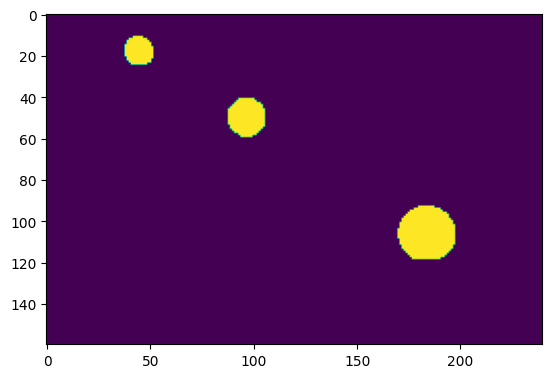

In [141]:
plt.imshow(tf.cast(unique_target_set_1[0] != 0, tf.float32))